### Basic concepts of supervised machine learning:

This notebook (or more precisely the person who wrote it) assumes that you are familiar with python at least to some extent.

Make sure you have installed anaconda, and created required conda environment. See supplied README.md file.

In [1]:
# Import the required libraries
import pandas as pd # pandas deals with handling data. 
import numpy as np # Numpy provdes a lot of FAST ways for array manipulation in python.
import matplotlib.pyplot as plt # Plotting script library
import matplotlib as mpl # Plotting
import seaborn as sns # More plotting

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid", {"axes.facecolor": ".97"})

### Supervised ML:
Supervised ML is about estimating probabilities of events using already seen training data $(\mathbf{X}_\text{train}, \mathbf{y}_\text{train})$ and model $\mathcal{M}$. We assume that there exists some reasonable underlying function $f(\mathbf{x})$ that we try to estimate. 

#### Classification:
The task is to predict probabilities of classes $y_i \in \mathbf{y}_\text{train}$ for given instance $\mathbf{x}$, i.e., $\mathcal{C}(\mathbf{x}) = [p(y_1), \ldots,p(y_N)]$. That is, classifier $\mathcal{C}: \mathcal{R}^{\text{dim}(x)} \rightarrow [0, 1]^{\text{nclasses}}$.  

#### Regression:
The task is to predict the probability of each value $\mathbf{y}$ for given regressor $\mathcal{G}(\mathbf{x}) = p(\mathbf{y})$. That is, regressor $\mathcal{G}: \mathcal{R}^{\text{dim}(x)} \rightarrow \mathcal{R}^{\text{dim}(y)}$.  

### Supervised Classification:
#### First we would like to import some example data to work with:
We list the first and then choose the one considering penguins. We also print out the features in the dataset:

In [3]:
display(sns.get_dataset_names())
data = sns.load_dataset('penguins')
data.head()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


### The first thing you always need to do (if you want to evaluate your classifiers performance) is to separate the data into train and test sets!

We further decide to build a classifier that would try to identify the penguin species given only the 2-features (xlabel, ylabel).

In [72]:
target = 'species'
xlabel = 'bill_length_mm'
ylabel = 'bill_depth_mm'

# shuffle the data and drop nans
data = data.sample(frac=1).dropna()
X = data.drop(columns=[target])  
X = X.loc[:, [xlabel, ylabel]]
y = data.species

N_train = 300
X_train = X.iloc[:N_train]
y_train = y.iloc[:N_train]
X_test = X.iloc[N_train:]
y_test = y.iloc[N_train:]

#### Then let us quickly plot some of the features out there:

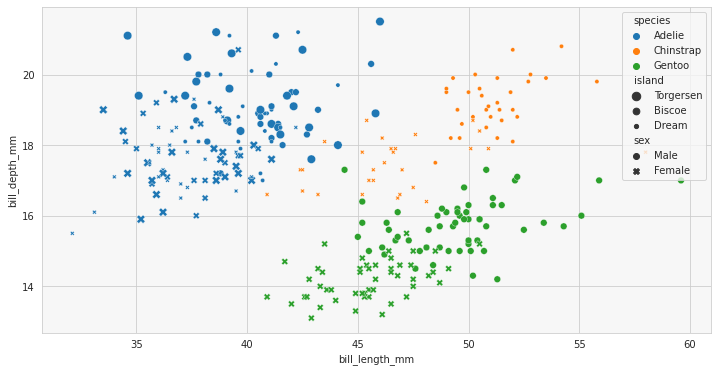

In [8]:
_ = sns.scatterplot(data=X_train, 
                    x=xlabel, 
                    y=ylabel, 
                    hue=y_train, 
                    style=data.sex, 
                    size=data.island)

### Supervised classifiers revised:

#### We now would like to build a classifer $C$ that is cabable of figurein out the species of penguin given the other information in the data.
A classifier $C$ is a mapping from the feature values to probabilites of classes:

$
C : \mathcal{R}^{\text{nfeatures}} \rightarrow \mathcal{R}^{\text{nclasses}}
$

That is, for given instance $\mathbf{x}$ we have $\mathcal{C}(\mathbf{x})=[p_\text{Adelia}, p_\text{Chinstrap}, p_\text{Gentoo}]$, where $p_i$ is the probability for class $i$.

The only thing left to do is to figure out a classifier that could provide such an mapping $\mathcal{C}$. Looking at the figure above it is evident that for any given $\mathbf{x}$ we could consider some 'similarity' measure - how similar this $\mathbf{x}$ is to some instance in the already seen data of penguins. 

Let us propose a classifier of type,

$\mathcal{C}:\mathcal{R}^\text{nfeatures}\rightarrow\mathcal{R}^\text{nclasses}$

$p_i = \mathcal{C}({\mathbf{x}})_i \propto \frac{1}{min(\{ D(\mathbf{x}, \mathbf{x}') : \mathbf{x}' \in X_\text{train} \})}$,

Now the predicted class is always the class corresponding to instance $\mathbf{x}'\in\mathbf{X}_\text{train}$ for which the distance $D(\mathbf{x}, \mathbf{x}')$ is minimized. Such a classifier is called first nearest neighbor classifier for the obvious reason that it picks the class label for instance $\mathbf{x}$ to equal the class label of $\mathbf{x}' \in \mathbf{X}_\text{train}$ for which distance $D(\mathbf{x}, \mathbf{x}')$ is the smallest.


### Make knn-classifier class:

The above described 1-nn classifier can immediately be generalized into knn classifier, where istead of the single nearest neighbor we consider the $k$ nearest neighbors (knn). 

Let $nn_{\mathbf{x}} = \{ (\mathbf{x}', y) : \text{the k nearest neighbors as given by distance metric } D(\mathbf{x}, \mathbf{x}'), ~ \mathbf{x}' \in \mathbf{X}_\text{train}  \}$
We get the probability for class $y_i$ via 

$p(y_i) = |\{y:  nn_\mathbf{x}(y) = y_i \}|/k$

In [55]:
class knn_classifier():
    """
    This is a simple knn classifier to demonstrate how one can build a classifier.
    NOTE!
    You should not build your own classifiers but rather use already implemented ones from
    libraries like scikit-learn, tensorflow etc. Reasons to make one yourself are
    1. You think you can do it better than rest.
    2. You want to learn how a classifier works and thus build it yourself.
    """
    def __init__(self, k=1):
        self.k = k
    
    def fit(self, X_train, y_train):
        """
        We fit the knn classifier by providing the training data and corresponding labels.
        Args:
            X_train: The training data.
            y_train: The training data class labels.
        Return:
            self:
        """
        self.X_train = X_train.values
        self.y_train = y_train.values
        
        return self
    
    def predict(self, x):
        """
        Predict using the knn classifier.
        Args:
            x: predict for this instance.
        Returns:
            y_pred: Predicted class labels.
            probs: Probabilitites of y_pred
            neighbor_idxs: List of indices of the nearest neighbors (used for plotting).
        """
        if (self.X_train is None) or (y_train is None):
            raise AttributeError('Classifier is not fitted!')
        
        if isinstance(x, pd.Series):
            x = x.values
        
        distances = np.sqrt(((self.X_train - x)**2).sum(axis=1))
        
        sort_idx = distances.argsort()
        
        targets, counts = np.unique(self.y_train[sort_idx[:self.k]], return_counts=True)
        probs = counts/counts.sum()
        sort_probs_idx = probs.argsort()
        
        return targets[sort_probs_idx], probs[sort_probs_idx], sort_idx[:self.k]
        

### Apply the above knn classifier to infer the class labels of unseen instances $\mathbf{x}$.

P(Gentoo) = 1.000


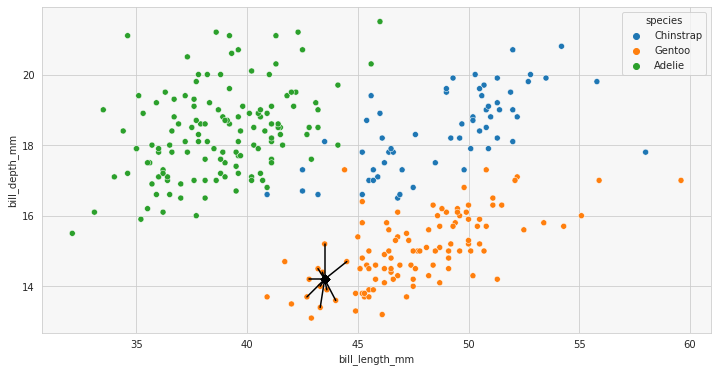

In [104]:
# The number of neighbors to consider:
k = 10

# Create and fit the classifier:
knn = knn_classifier(k=k).fit(X_train, y_train)

# Pick a test index, the test instance is then drawn from the above separated test set.
test_idx = 2
x_test = X_test.iloc[test_idx]

# Call the predict of 1-nn classifier:
y_preds, probs, idxs = knn.predict(x_test)

# Print the probabilites gfor each class:
prob_str = 'P({0:}) = {1:.3f}'
for y_pred, prob in zip(y_preds, probs):
    print(prob_str.format(y_pred, prob))

# Plot figure where the nearest neighbors are explicitly shown:
_ , ax = plt.subplots()
ax = sns.scatterplot(data=X_train, 
                     x=xlabel, 
                     y=ylabel, hue=y_train, ax=ax)

for idx in idxs:
    xtest_x = x_test.loc[xlabel] 
    xtest_y = x_test.loc[ylabel]
    ax.scatter(xtest_x, xtest_y, marker='D', color='black')
    nn_x = X_train.iloc[idx][xlabel]
    nn_y = X_train.iloc[idx][ylabel]
    ax.plot([xtest_x, nn_x], [xtest_y, nn_y], color='black')
plt.show()

### Classifier performance evaluation:

Looking at the above figure it is prettu obvious that one does not need complicated model to figure out the penguin species given the two features. However, we might ask questions like: "How good is the classifier that we just built?". How do we estimate it? 

The first thing to note is again - you test with *unseen* data! For example 1-nn classifier would always yield the correct class when tested with data that was used to train it. The importance of separating the data into training and testing sets cannot be emphasized enough!

Anyhow, suppose you remebered to make the division and now you are to evaluate the the performance of you classifier using the *unseen* test data $(\mathbf{X}_\text{test}, \mathbf{y}_\text{test})$. The most obvious measure of performance for your classifier could be: 

$
\text{accuracy} = \frac{\text{number_of_correct_predictions}}{\text{number_of_predictions}}.
$

However, accuracy has several noted issues. Consider for example situation where you want to pick a rare disease (only 1 person in 100 000 has it) and you receive an accuracy score of 99.999%! You think you are doing great, but think twice. You notice the issue? (explanation at the the end of notebook...)

However, we for now use accuracy to demonstrate the evaluation process. 

In [105]:
y_preds = np.zeros(len(X_test), dtype='object')
for i, x_test in enumerate(X_test.values):
    # Predicted class is the one with largest probability, which in turn is the last element in the list.
    y_preds[i] = knn.predict(x_test)[0][-1]
    
#compare y_preds element vise with the known truth y_test
correct_prediction_array = y_preds == y_test.values

# accuracy is the fraction of correct predicions over all predictions
accuracy = correct_prediction_array.sum()/len(y_preds)

print('Accuracy of the {}-nn model is {:.1f}%'.format(k, 100*accuracy))

Accuracy of the 10-nn model is 90.9%


The simple knn classifier seems to provide rather good results, but the process was tedious and can be significantly simplified.

### Going further - start using libraries:

Obviously we are not going to be building classifiers and evaluating metrics in the manner presented above. This all has been prebuild into several libraries. In python the most popluar is scikit-learn. Let us now see how the above would have been done using *scikit-learn*.

In [119]:
# Import the knn classifier class and a cross validation function from sklearn libraries.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Pick data:
X = data.drop(columns=target)
X = X.loc[:, [xlabel, ylabel]]
y = data.loc[:, target]

# Create the classifier
knn = KNeighborsClassifier(n_neighbors=k)

# Choose the performance evalaution metric:
metric = 'accuracy'

# Perform cross validation
test_scores = cross_validate(knn, X, y, cv=10, scoring=metric)['test_score']

# Show results:
for i, score in enumerate(test_scores):
    print('{} in test split {} = {:.1f}%'.format(metric, i, 100*score))

print()
print('{} = {:.3f}, std = {:.3f}'.format(metric, test_scores.mean(), test_scores.std()))    


accuracy in test split 0 = 97.1%
accuracy in test split 1 = 97.1%
accuracy in test split 2 = 97.1%
accuracy in test split 3 = 97.0%
accuracy in test split 4 = 93.9%
accuracy in test split 5 = 97.0%
accuracy in test split 6 = 90.9%
accuracy in test split 7 = 93.9%
accuracy in test split 8 = 100.0%
accuracy in test split 9 = 90.9%

accuracy = 0.955, std = 0.028


#### Lets go through the above:

First one imports the **KNeighborsClassifier** and a function to perfrom cross validation.

The data is then selected as before - this is just to remind ourselves where the data came from.

Create the knn classifier.

Choose a performance evalaution metric - here accuracy.

Perform the **cross validation**. Now this is different from above, where we only evaluated the perfromance our knn-classifier in a single test set. Cross validation is basically just splitting the data into N slices. Each of the N slices is at its time the test set while the rest of the data is used for training the classifier (knn). This is useful and give more confidence into the performance evalaution process, since you can be confident that you did not accidentally pick up the easiest possible test set - every instance in the data will be at their time part of the test set as well.



### Training supervised regressor using scikit-learn:

Training a model is the process where you use the training data $(\mathbf{X}_\text{train}, \mathbf{y}_\text{train})$ to modify parameters of the model $\mathcal{M}$ so that you expect the resulting model somehow capture the underlying true function $f$. For knn classifier training meant only to provide the training data and the class labels, but this process can be obviously more elaborate. 

The second simplest thing is to consider linear regression. We can take a single species from the data **Gentoo** and see if we can estimate the 'bil_depth' using the 'bil length'.

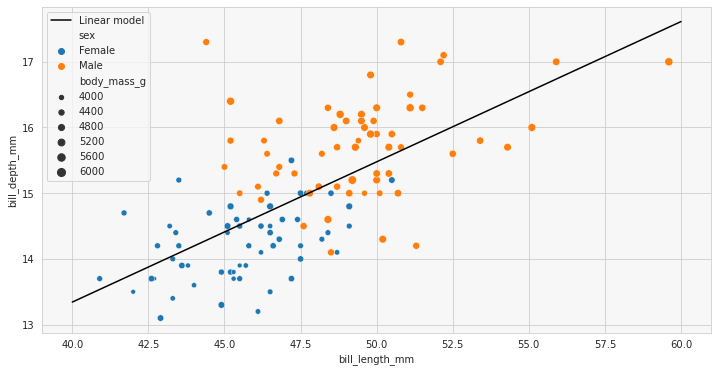

In [169]:
# select only single species from the data
species = 'Gentoo'
mask = data.species == species

# Import the linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X = data.loc[mask, xlabel].values.reshape(-1, 1)
y = data.loc[mask, ylabel]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)

# We fit the linear model to training data:
linreg = LinearRegression().fit(X_train, y_train)

ax = sns.scatterplot(data=data[mask], x=xlabel, y=ylabel, hue='sex', size='body_mass_g')
xrange = np.linspace(40, 60, 10)
ax.plot(xrange, linreg.coef_[0]*xrange + linreg.intercept_, color='black', label='Linear model')
_ = plt.legend()

The 'predictions' given by the regressor (linreg) are shown as the black line. We shall not dwell into scoring of such a fit, but note that notice how here 'machine learning' reminds quite a bit of traditional statistics. What separates ML from regular modeling that most of the time you do not care to *understand* the system or the system is so complicated that it is completely impossible to find reasonable models (consider for example image recognition). However, it is not too rare that a given ML task can be solved by simple methods with the added benefit that usually those methods are also easier (or at least possible) to interpret see: https://community.fico.com/s/blog-post/a5Q2E0000001czyUAA/fico1670 

The reson accuracy is bad in the 